In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade

In [ ]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from IPython.display import clear_output
from typing import NamedTuple
from datetime import timedelta, datetime
import yfinance as yf

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt


class SinglePeriod:
    def __init__(
        self,
        data,
        preds,
        budget,
        init_budget,
        sampler_args,
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):

        self.df = data
        self.preds = preds
        self.budget = budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.init_budget = budget

        #print('self.df.columns')
        #print(self.df.columns)
        self.stocks = self.df.columns.tolist()
        self.init_holdings = init_holdings
        #print(f'self.init_holdings in single period: {init_holdings}')

        self.pct_returns = self.df.pct_change()

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")
        #print(f'self.alpha: {self.alpha}')

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}

        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        print('sampler properties')
        print(self.sampler['CQM'].properties)
        sys.exit()
        self.solution = {}
        self.precision = 2


    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        self.max_num_shares = (self.budget/self.df.loc[idx,:]).astype(int)

        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}

        print(f'idx in single period: {idx}')
        self.price = self.df.loc[idx, :]
        print('price')
        display(self.price)
        self.daily_returns = self.pct_returns.loc[:idx, :]
        print('daily returns')
        display(self.daily_returns)
        self.avg_daily_returns = self.preds.pct_change().loc[idx, :]
        print('avg daily returns')
        display(self.avg_daily_returns)
        self.covariance_matrix = self.daily_returns.cov()

        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]

        print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]

        print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            print(f'init holdings total value: {sum([self.price[s]*self.init_holdings[s] for s in self.stocks])}')
            #self.budget = sum([self.price[s]*self.init_holdings[s] for s in self.stocks])
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0
            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')

            print(f'budget in cqm: {self.budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')


        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            #print('cqm debugging')
            # print(f'risk: {type(risk)}')
            # print(f'returns: {type(returns)}')
            #print(returns)

            cqm.set_objective(self.alpha * risk - returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm
        return self.model



    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.model = self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        variance = 0.0
        for s1, s2 in product(solution, solution):
            #print(f'stock: {stock}, price1: {self.price[s1]}, price2: {self.price[s2]}, covariance_matrix: {self.covariance_matrix[s1][s2]}')
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        #tmp_daily_retuns = self.avg_daily_returns.loc[idx, :]
        for stock in solution:
            #print(f'stock: {stock}, price: {self.price[stock]}, avg_daily_returns: {self.avg_daily_returns[stock]}')
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]
            #est_return += solution[stock]*self.price[stock]*self.tmp_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [ ]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self,
                data,
                forecast,
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):

        self.save_path = save_path
        self.df = data
        self.preds = forecast
        print('self.preds')
        display(self.preds)
        self.stocks = self.df.columns.values.tolist()

        self.sampler_args = sampler_args
        self.budget = budget
        self.init_budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type

        initial_gspc = self.baseline.query('ds==@dates[0]').values.tolist()[0][0]
        # print('initial baseline')
        # display(self.baseline)
        # print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        # print('final baseline')
        # display(self.baseline)
        # print('initial data')
        # display(self.df.head())

        self.init_holdings = init_holdings
        # if init_holdings is not None:
        #     self.init_holdings = init_holdings
        # else:
        #     self.init_holdings = {s:0 for s in self.stocks}

        # print('iniital_holdings')
        # print(self.init_holdings)

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        # print('init holdings keys')
        # print(set(self.init_holdings.keys()))
        #self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = self.df.columns.values.tolist()
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)
        self.sample_set = {}
        self.sampler_args = sampler_args
        self.solution = {}

    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """

        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []

        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'est_returns', 'value'])


        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')

            previous_idx = idx - timedelta(days=1)
            self.price = self.df.loc[idx, :]
            print('price')
            display(self.price)
            baseline_current = self.baseline.loc[idx, :]

            if first_purchase:
                self.budget = self.init_budget
                #self.agg_results = pd.DataFrame([{'idx': idx, 'variance': 0.0, 'est_returns': 0.0, 'value': sum([self.price[s]*self.init_holdings[s] for s in self.stocks])}])

                print('preds')
                display(self.preds.loc[idx, :])
                print(f'budget in Multiperiod: {self.budget}')

                first_purchase = False
            else:
                self.budget = sum([self.price[s] * self.init_holdings[s] for s in self.stocks])
                print(f'budget in Multiperiod: {self.budget}')

            single_period = SinglePeriod(data=self.df.loc[:idx, :],
                                            preds=self.preds,
                                            budget=self.budget,
                                            init_budget = self.init_budget,
                                            sampler_args=self.sampler_args,
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            baseline_shares = (self.budget / baseline_current)
            #display(self.baseline)
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            returns = self.solution['return']
            variance = self.solution['risk']
            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'est_returns': returns, 'value': value}])])

            #initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / self.budget - 1
            display(self.agg_results)

            # fig = plt.figure(figsize=(10.708,8.2))
            # sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            # sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            # plt.show()
            # print(f'\nRun completed.\n')

        return self.agg_results

In [ ]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)

    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)

    # Read in baseline data; resample to monthly
    index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    df_baseline = pd.DataFrame(index=index_df.index, columns=baseline)
    for i in baseline:
        df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [ ]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [ ]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:
                if b == '0':
                    inverse_s += '1'
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)

            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            print(total)
            if total <= budget and total > 0.6 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(score_report)
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0
    # enumerate generations
    for gen in range(n_iter):
        print(gen)
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]

        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
            ax[0].hist(scores)
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [ ]:
initial_date = '2021-01-01'
end_date = '2021-07-01'
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
ticker_list = first_table['Symbol'].values.tolist()
source = yf.download(ticker_list, start=initial_date, end=end_date)[['Close']]
df_src = source.copy()
df_src.columns = df_src.columns.droplevel(0)
df_src.dropna(axis=1, inplace=True)
stock_list = df_src.columns.values.tolist()
df_src.reset_index(inplace=True)
df_src.rename(columns={'Date':'ds'}, inplace=True)
df_src.set_index('ds', inplace=True)
df_src.head()

[*********************100%%**********************]  503 of 503 completed

ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-01 -> 2021-07-01)')
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:['GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1609477200, endDate = 1625112000")


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-04,118.639999,15.13,157.339996,129.410004,105.410004,96.500000,109.110001,34.900002,256.459991,485.339996,...,106.900002,65.660004,41.500000,53.750000,99.690002,105.820000,148.699036,378.130005,42.930000,163.589996
2021-01-05,119.610001,15.43,157.169998,131.009995,106.500000,97.760002,110.459999,35.040001,257.920013,485.690002,...,110.190002,65.019997,43.500000,55.290001,99.570000,105.830002,151.271851,380.570007,43.610001,164.729996
2021-01-06,122.889999,15.52,166.250000,126.599998,105.580002,106.169998,110.230003,36.580002,260.739990,466.309998,...,110.849998,66.459999,44.610001,57.959999,103.769997,106.410004,155.582520,394.820007,48.509998,167.149994
2021-01-07,126.160004,15.38,167.669998,130.919998,106.709999,110.129997,111.300003,36.240002,263.200012,477.739990,...,109.750000,65.160004,44.959999,57.660000,108.480003,105.599998,154.660187,409.100006,49.990002,167.000000
2021-01-08,127.059998,15.13,170.059998,132.050003,107.269997,110.029999,111.610001,36.439999,264.160004,485.100006,...,109.029999,65.760002,45.459999,58.180000,107.379997,107.150002,154.320389,405.470001,48.720001,168.110001


In [ ]:
initial_date = '2021-01-01'
end_date = '2021-07-01'
source = yf.download(['^GSPC'], start=initial_date, end=end_date)[['Close']]
df_baseline = source.copy()
display(df_baseline.head())
df_baseline = source[['Close']]
df_baseline.dropna(axis=1, inplace=True)
df_baseline.reset_index(inplace=True)
df_baseline.rename(columns={'Date':'ds'}, inplace=True)
df_baseline.set_index('ds', inplace=True)
df_baseline.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


,Close
ds,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


In [ ]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.0001,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.0,
            'n_iter': 100,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'Experiment 7',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}

df_forecast_init = pd.read_pickle('/content/drive/MyDrive/models/lgbm_20_backtest.pkl')
df_forecast_init.index.names = ['ds']
print('df_forecast_init')
display(df_forecast_init.tail())
n_stocks = 10
stocks = df_forecast_init.columns.values.tolist()[:n_stocks]

# print('df')
# display(df.loc[:, stocks].shift(1).head())
# display(df.loc[:, stocks].shift(1).tail())
df = df_src.loc[:, stocks].shift(1)
df.dropna(inplace=True)
display(df.head())


#df_forecast = df_src.loc[:, stocks].copy()
df_forecast = pd.concat([df.loc[:(datetime.strptime(cfg['dates'][0], '%Y-%m-%d') - timedelta(days=1)), :], df_forecast_init.loc[:, stocks]], axis=0)


df_forecast_init


component,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ
ds,,,,,,,,,,,,,,,,,,,,
2021-06-24,144.533275,22.311011,200.618412,134.000369,114.444677,117.137398,110.770653,38.518082,286.168220,557.019597,163.760820,61.415389,195.987823,283.222162,82.608674,83.349458,25.624797,52.799280,47.613560,154.537456
2021-06-25,145.644250,22.329560,200.331560,133.175076,114.856547,116.654139,111.652757,38.897167,288.404758,558.395945,165.247477,61.819882,196.153547,287.207009,81.194616,83.090155,25.801721,52.910658,47.802288,155.703599
2021-06-28,144.867553,22.435920,202.416632,133.355656,113.439567,116.168338,112.102045,39.150949,291.016352,558.459812,166.915255,61.930524,196.802058,288.886774,81.919258,84.270725,26.230586,54.662100,49.180730,157.439943
2021-06-29,145.405624,21.009751,204.094801,134.260115,112.648726,114.900173,113.982671,38.643299,291.487102,570.658734,166.156724,61.283882,195.745522,295.854965,81.933233,85.141641,26.788827,53.393008,47.777303,156.951892
2021-06-30,146.019711,21.378169,204.518649,134.139080,112.492505,115.130130,114.293718,39.001348,291.728585,571.483641,168.679069,61.458320,195.428718,295.781137,80.670301,83.853520,26.031758,53.714718,47.578363,156.551092


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE
ds,,,,,,,,,,
2021-01-05,118.639999,15.13,157.339996,129.410004,105.410004,96.500000,109.110001,34.900002,256.459991,485.339996
2021-01-06,119.610001,15.43,157.169998,131.009995,106.500000,97.760002,110.459999,35.040001,257.920013,485.690002
2021-01-07,122.889999,15.52,166.250000,126.599998,105.580002,106.169998,110.230003,36.580002,260.739990,466.309998
2021-01-08,126.160004,15.38,167.669998,130.919998,106.709999,110.129997,111.300003,36.240002,263.200012,477.739990
2021-01-11,127.059998,15.13,170.059998,132.050003,107.269997,110.029999,111.610001,36.439999,264.160004,485.100006


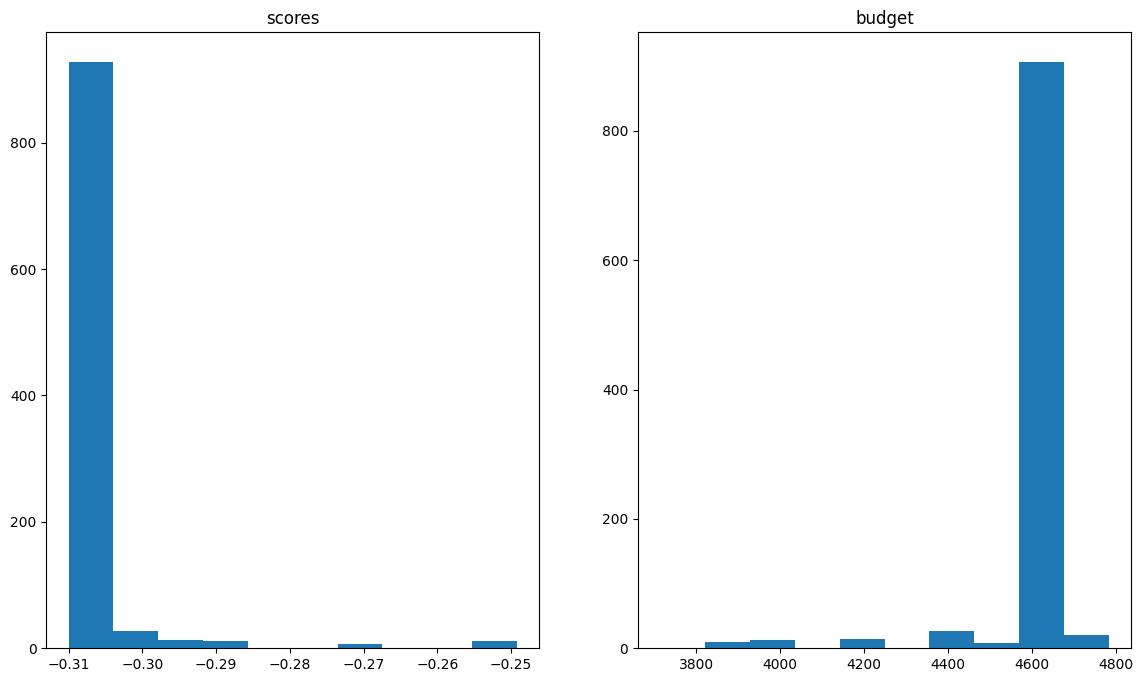

90 best eval:-0.3100120166000049
mean score: -0.3082485185557961
best total: 4671.420021057129
91
92
93
94
95
96
97
98
99
best: [ 7  0  5  6  0  0  8 19  1  1]
best_eval: -0.3100120166000049
best_total: 4671.420021057129
pop: [7, 0, 5, 6, 0, 0, 8, 19, 1, 1]


In [ ]:
init_holdings_df, budget = generate_initial_state(df, cfg['n_iter'], cfg['r_cross'], cfg['r_mut'], cfg['n_pop'], cfg['budget'])
init_holdings_df.to_pickle(cfg['save_path']+'init_holdings.pkl')

#init_holdings_df = pd.read_pickle(cfg['save_path']+'init_holdings.pkl')
init_holdings = {}

for idx, row in init_holdings_df.iterrows():
    init_holdings.update({row['a']: row['b']})

prices = df.loc[cfg['dates'][0], :].values.tolist()
pop = init_holdings_df['b'].values.tolist()
print(f'pop: {pop}')
budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])

In [ ]:
# fig = plt.figure(figsize=(10.708,8.2))
# sns.scatterplot(x='ds', y=df_forecast_init.sum(axis=1), data=df_forecast_init, label='Forecast')
# sns.scatterplot(x='ds', y=df.sum(axis=1), data=df.loc['2021-06-01':, :], label='Ground Truth')
# # sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
# # sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
# plt.show()

In [ ]:
my_portfolio = MultiPeriod(data=df,
                        forecast=df_forecast,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=cfg['sampler_args'],
                        dates=cfg['dates'],
                        file_path=cfg['file_path'],
                        model_type=cfg['model_type'],
                        alpha=cfg['alpha'],
                        verbose=cfg['verbose'],
                        t_cost=cfg['t_cost'],
                        label=cfg['label'],
                        init_holdings=init_holdings,
                        save_path=cfg['save_path']+cfg['label']+'/'
                        )

df_results = my_portfolio.run(min_return=cfg['min_return'], max_risk=cfg['max_risk'], num=cfg['num'])

self.preds


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE
ds,,,,,,,,,,
2021-01-05,118.639999,15.130000,157.339996,129.410004,105.410004,96.500000,109.110001,34.900002,256.459991,485.339996
2021-01-06,119.610001,15.430000,157.169998,131.009995,106.500000,97.760002,110.459999,35.040001,257.920013,485.690002
2021-01-07,122.889999,15.520000,166.250000,126.599998,105.580002,106.169998,110.230003,36.580002,260.739990,466.309998
2021-01-08,126.160004,15.380000,167.669998,130.919998,106.709999,110.129997,111.300003,36.240002,263.200012,477.739990
2021-01-11,127.059998,15.130000,170.059998,132.050003,107.269997,110.029999,111.610001,36.439999,264.160004,485.100006
...,...,...,...,...,...,...,...,...,...,...
2021-06-24,144.533275,22.311011,200.618412,134.000369,114.444677,117.137398,110.770653,38.518082,286.168220,557.019597
2021-06-25,145.644250,22.329560,200.331560,133.175076,114.856547,116.654139,111.652757,38.897167,288.404758,558.395945
2021-06-28,144.867553,22.435920,202.416632,133.355656,113.439567,116.168338,112.102045,39.150949,291.016352,558.459812


num_days: 22
idx: 2021-06-01 00:00:00
price


A       138.130005
AAL      24.240000
AAP     189.729996
AAPL    124.610001
ABBV    113.199997
ABC     114.739998
ABT     116.650002
ACGL     39.889999
ACN     282.160004
ADBE    504.579987
Name: 2021-06-01 00:00:00, dtype: float64

preds


A       135.783294
AAL      24.246519
AAP     191.890420
AAPL    124.884786
ABBV    111.899694
ABC     115.806999
ABT     110.289678
ACGL     39.816088
ACN     282.960935
ADBE    495.265230
Name: 2021-06-01 00:00:00, dtype: float64

budget in Multiperiod: 5141.070007324219
sampler properties
{'minimum_time_limit_s': 5, 'num_variables_multiplier': 0.000157411458, 'num_biases_multiplier': 4.65705646e-06, 'num_constraints_multiplier': 6.44385747e-09, 'maximum_time_limit_hrs': 24.0, 'maximum_number_of_variables': 500000, 'maximum_number_of_quadratic_variables': 100000000, 'maximum_number_of_biases': 2000000000, 'maximum_number_of_constraints': 100000, 'maximum_number_of_quadratic_variables_real': 0, 'maximum_number_of_linear_biases_real': 200000000, 'parameters': {'time_limit': 'Maximum requested runtime in seconds.'}, 'supported_problem_types': ['cqm'], 'category': 'hybrid', 'version': '1.12', 'quota_conversion_rate': 20}


SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#df_results.to_pickle(cfg['save_path']+'results_model_test1.pkl')

In [ ]:
df_base = (df.loc['2021-06-01':, :].sum(axis=1) / df.loc['2021-06-01', :].sum()).reset_index()
df_base.head()

In [ ]:
df_results.head()

In [ ]:
df_results_idx = df_results.set_index('idx')
display(df_results_idx.head())
df_results_norm = (df_results_idx.value / df_results_idx.iloc[0, 2]).to_frame().reset_index()
df_results_norm.head()

Experiment 1: 4 stocks using ground truth as forecasting, alpha = 0.01

Experiment 2: 4 stocks using lgbm forecasting, alpha = 0.01

Experiment 3: 6 stocks using lgbm forecasting, alpha = 0.01 - results degraded compared to 2

Experiment 4: 6 stocks using lgbm forecasting, alpha = 1.0 - results degraded compared to 3

Experiment 5: 6 stocks using lgbm forecasting, alpha = 0.001 - results improved compared to 4

Experiment 6: 10 stocks using lgbm forecasting, alpha = 0.001 - results degraded compared to 5

In [ ]:
df_results_norm.to_pickle(cfg['save_path']+'df_results_norm_experiment7.pkl')

In [ ]:
#fig, ax = plt.subplot(1)
fig = plt.figure(figsize=(10.708,8.2))
sns.scatterplot(x=df_results_norm.idx, y=df_results_norm.value, label='Results')
sns.scatterplot(x='ds', y=0, data=df_base, label='Ground Truth')
plt.show()

In [ ]:
# self.output.to_pickle(self.save_path+'output.pkl')
# self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
# self.baseline.to_pickle(self.save_path+'baseline.pkl')